In [ ]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:



MARK_PATH   = "/content/drive/MyDrive/Colab Notebooks/HeatMap/Data/mark.csv"
TACKLE_PATH = "/content/drive/MyDrive/Colab Notebooks/HeatMap/Data/tackle.csv"
KICK_PATH   = "/content/drive/MyDrive/Colab Notebooks/HeatMap/Data/kick.csv"


OUTPUT_DIR = "./heatmap_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/HeatMap"


 Data  'HeatMap output 3.ipynb'


In [ ]:


GROUND_LENGTH_M = 165.0
GROUND_WIDTH_M  = 135.0

HALF_LENGTH_M = GROUND_LENGTH_M / 2.0
HALF_WIDTH_M  = GROUND_WIDTH_M  / 2.0

NX, NY = 200, 150
SIGMA  = 2.0

WEIGHT_MODE = "conf*visibility"

In [ ]:


REQUIRED_COLS = ["frame_id", "track_id", "x", "y", "width", "height", "conf", "class_id", "visibility"]

def assert_schema(df: pd.DataFrame, path: str):
    missing = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing:
        raise ValueError(
            f"{path} is missing required columns: {missing}\n"
            f"Found columns: {list(df.columns)}"
        )

def load_events_csv(path: str, event_name: str = "") -> pd.DataFrame:

    df = pd.read_csv(path)
    assert_schema(df, path)
    # Basic sanity cleanup
    df = df.dropna(subset=["x", "y"]).copy()
    # Ensure numeric types (robust to any stray strings)
    for c in ["x", "y", "width", "height", "conf", "visibility"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["x", "y"]).copy()
    # Optional: ensure arrays are finite
    df = df[np.isfinite(df["x"]) & np.isfinite(df["y"])]
    return df

def choose_weights(df: pd.DataFrame, mode: str | None):
    if mode is None:
        return None
    m = mode.lower().strip()
    if m == "conf":
        return df["conf"].to_numpy(dtype=float)
    if m == "visibility":
        return df["visibility"].to_numpy(dtype=float)
    if m in ("conf*visibility", "visibility*conf"):
        conf = df["conf"].fillna(0).to_numpy(dtype=float)
        vis  = df["visibility"].fillna(0).to_numpy(dtype=float)
        return conf * vis
    # default fallback: no weights
    return None


In [ ]:


def raw_bbox(x, y, pad_ratio=0.02):

    xmin, xmax = float(np.min(x)), float(np.max(x))
    ymin, ymax = float(np.min(y)), float(np.max(y))
    dx, dy = xmax - xmin, ymax - ymin
    return (xmin - dx*pad_ratio, xmax + dx*pad_ratio,
            ymin - dy*pad_ratio, ymax + dy*pad_ratio)

def raw_to_metres(x, y, bbox_raw, a, b):

    xmin, xmax, ymin, ymax = bbox_raw
    x_m = ((x - xmin) / max(1e-9, (xmax - xmin))) * (2*a) - a
    y_m = ((y - ymin) / max(1e-9, (ymax - ymin))) * (2*b) - b
    return x_m, y_m

def make_oval_mask_metres(nx, ny, a, b):

    x_edges = np.linspace(-a, a, nx + 1)
    y_edges = np.linspace(-b, b, ny + 1)
    xc = (x_edges[:-1] + x_edges[1:]) / 2
    yc = (y_edges[:-1] + y_edges[1:]) / 2
    Xc, Yc = np.meshgrid(xc, yc)
    mask = (Xc**2) / (a**2) + (Yc**2) / (b**2) <= 1.0
    return x_edges, y_edges, mask

def heatmap_in_metres(x_raw, y_raw, bbox_raw, a, b, nx=NX, ny=NY, sigma=SIGMA, weights=None):

    x_m, y_m = raw_to_metres(np.asarray(x_raw, float), np.asarray(y_raw, float), bbox_raw, a, b)
    x_edges, y_edges, mask = make_oval_mask_metres(nx, ny, a, b)
    H, _, _ = np.histogram2d(x_m, y_m, bins=[x_edges, y_edges], weights=weights)
    H = H.T
    Hs = gaussian_filter(H, sigma=sigma)
    Hs_masked = np.where(mask, Hs, np.nan)
    return Hs_masked, x_edges, y_edges



In [ ]:


def draw_afl_field_metres(ax, a, b,
                          centre_square=50.0,
                          centre_inner_d=3.0,
                          centre_outer_d=10.0,
                          goal_square_depth=9.0,
                          goal_square_width=6.4,
                          arc_r=50.0,
                          line_color="white", lw=2.0, alpha=0.95,
                          show_ticks=False):
    t = np.linspace(0, 2*np.pi, 800)

    # Oval boundary
    ax.plot(a*np.cos(t), b*np.sin(t), color=line_color, lw=lw, alpha=alpha)

    # Centre line
    ax.plot([0, 0], [-b, b], color=line_color, lw=lw, alpha=alpha*0.9)

    # Centre square (50 x 50)
    cs = centre_square/2.0
    ax.plot([-cs,  cs,  cs, -cs, -cs], [-cs, -cs, cs, cs, -cs], color=line_color, lw=lw-0.5, alpha=alpha*0.9)

    # Centre circles (outer 10 m, inner 3 m)
    th = np.linspace(0, 2*np.pi, 400)
    ax.plot((centre_outer_d/2.0)*np.cos(th), (centre_outer_d/2.0)*np.sin(th),
            color=line_color, lw=lw-0.5, alpha=alpha*0.9)
    ax.plot((centre_inner_d/2.0)*np.cos(th), (centre_inner_d/2.0)*np.sin(th),
            color=line_color, lw=lw-0.5, alpha=alpha*0.6)

    # 50 m arcs (semicircles at each end)
    phi_L = np.linspace(-np.pi/2, np.pi/2, 400)
    phi_R = np.linspace(np.pi/2, 3*np.pi/2, 400)
    ax.plot(-a + arc_r*np.cos(phi_L), 0 + arc_r*np.sin(phi_L),
            color=line_color, lw=lw-0.5, alpha=alpha*0.6)
    ax.plot( a + arc_r*np.cos(phi_R), 0 + arc_r*np.sin(phi_R),
            color=line_color, lw=lw-0.5, alpha=alpha*0.6)

    # Goal squares: 9 m deep x 6.4 m wide
    gs_w = goal_square_width/2.0
    # Left
    ax.plot([-a, -a+goal_square_depth, -a+goal_square_depth, -a, -a],
            [-gs_w, -gs_w, gs_w, gs_w, -gs_w], color=line_color, lw=lw-0.5, alpha=alpha*0.9)
    # Right
    ax.plot([ a,  a-goal_square_depth,  a-goal_square_depth,  a,  a],
            [-gs_w, -gs_w, gs_w, gs_w, -gs_w], color=line_color, lw=lw-0.5, alpha=alpha*0.9)

    # Goal line ticks (4 m either side of centre)
    tick = 4.0
    for xg in (-a, a):
        ax.plot([xg, xg], [-tick, tick], color=line_color, lw=lw, alpha=alpha)

    if show_ticks:
        ax.set_xlabel("Metres (X)")
        ax.set_ylabel("Metres (Y)")
        ax.set_xticks(np.arange(-a, a+1e-6, 20))
        ax.set_yticks(np.arange(-b, b+1e-6, 20))
        ax.grid(alpha=0.15, linewidth=0.8)
    else:
        ax.set_axis_off()

    ax.set_aspect('equal')

In [ ]:
def plot_heatmap_on_field_metres(H, x_edges, y_edges, a, b, title="", alpha_img=0.88, out_path=None):
    fig, ax = plt.subplots(figsize=(11, 8))
    extent = [x_edges.min(), x_edges.max(), y_edges.min(), y_edges.max()]

    finite_vals = H[np.isfinite(H)]
    vmax = (np.nanpercentile(finite_vals, 99) if finite_vals.size else np.nanmax(H)) or 1.0

    im = ax.imshow(
        H, origin="lower", extent=extent, aspect="equal",
        interpolation="bilinear", alpha=alpha_img,
        norm=Normalize(vmin=0.0, vmax=vmax)
    )

    draw_afl_field_metres(ax, a, b, show_ticks=False)

    # Simple 20 m scale bar
    sb_y = -b + 8
    sb_x0, sb_x1 = -a + 12, -a + 32
    ax.plot([sb_x0, sb_x1], [sb_y, sb_y], color="white", lw=4, alpha=0.95)
    ax.text((sb_x0+sb_x1)/2, sb_y-4, "20 m", ha="center", va="top", color="white", fontsize=11)

    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Intensity")
    plt.tight_layout()

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        fig.savefig(out_path, dpi=220)
    plt.show()
    plt.close(fig)

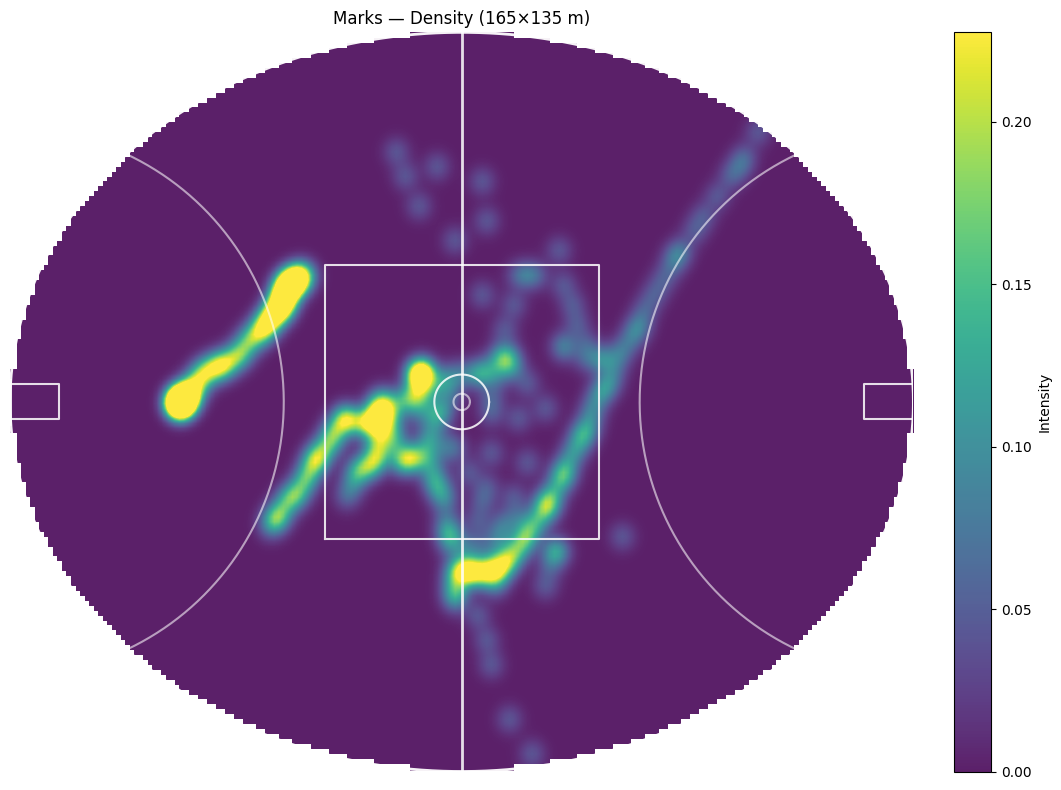

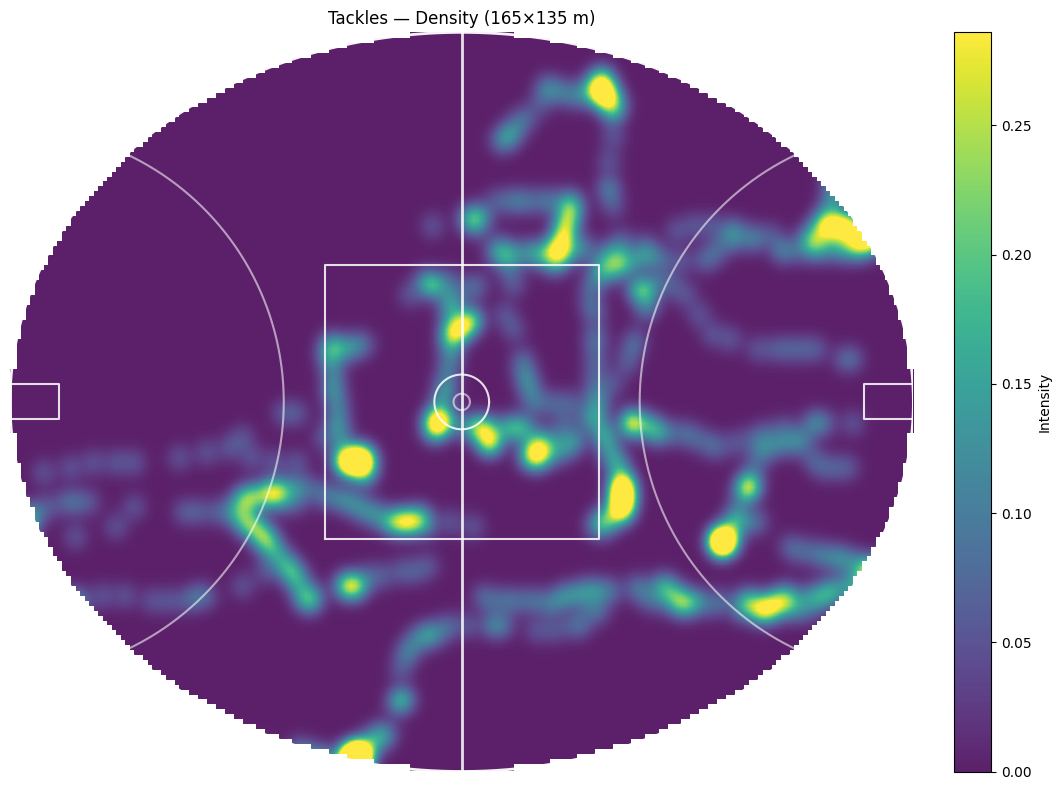

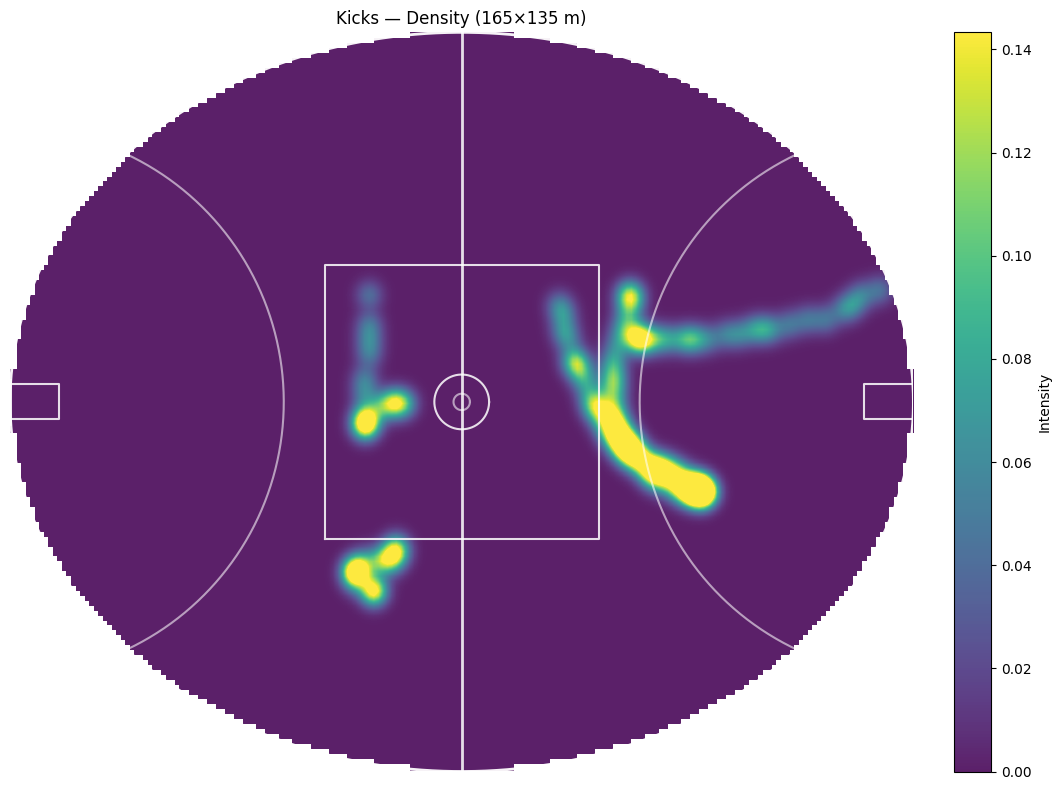

Done. Images saved in: /content/heatmap_outputs


In [ ]:


# Load CSVs (new headers assumed)
mark_df   = load_events_csv(MARK_PATH,   "mark")
tackle_df = load_events_csv(TACKLE_PATH, "tackle")
kick_df   = load_events_csv(KICK_PATH,   "kick")

# Extract raw coords + optional weights
x_mark, y_mark = mark_df["x"].to_numpy(),   mark_df["y"].to_numpy()
x_tac,  y_tac  = tackle_df["x"].to_numpy(), tackle_df["y"].to_numpy()
x_kick, y_kick = kick_df["x"].to_numpy(),   kick_df["y"].to_numpy()

w_mark = choose_weights(mark_df, WEIGHT_MODE)
w_tac  = choose_weights(tackle_df, WEIGHT_MODE)
w_kick = choose_weights(kick_df, WEIGHT_MODE)

# Build one shared raw bbox so all event types align spatially
all_x = np.concatenate([x_mark, x_tac, x_kick])
all_y = np.concatenate([y_mark, y_tac, y_kick])
shared_bbox_raw = raw_bbox(all_x, all_y)

# Compute metre-true heatmaps
H_mark_m, xe_m, ye_m = heatmap_in_metres(x_mark, y_mark, shared_bbox_raw, HALF_LENGTH_M, HALF_WIDTH_M, NX, NY, SIGMA, w_mark)
H_tac_m,  _,    _    = heatmap_in_metres(x_tac,  y_tac,  shared_bbox_raw, HALF_LENGTH_M, HALF_WIDTH_M, NX, NY, SIGMA, w_tac)
H_kick_m, _,    _    = heatmap_in_metres(x_kick, y_kick, shared_bbox_raw, HALF_LENGTH_M, HALF_WIDTH_M, NX, NY, SIGMA, w_kick)

# Plot/save
plot_heatmap_on_field_metres(
    H_mark_m, xe_m, ye_m, HALF_LENGTH_M, HALF_WIDTH_M,
    title=f"Marks — Density ({int(GROUND_LENGTH_M)}×{int(GROUND_WIDTH_M)} m)",
    out_path=f"{OUTPUT_DIR}/heatmap_mark_m.png"
)
plot_heatmap_on_field_metres(
    H_tac_m, xe_m, ye_m, HALF_LENGTH_M, HALF_WIDTH_M,
    title=f"Tackles — Density ({int(GROUND_LENGTH_M)}×{int(GROUND_WIDTH_M)} m)",
    out_path=f"{OUTPUT_DIR}/heatmap_tackle_m.png"
)
plot_heatmap_on_field_metres(
    H_kick_m, xe_m, ye_m, HALF_LENGTH_M, HALF_WIDTH_M,
    title=f"Kicks — Density ({int(GROUND_LENGTH_M)}×{int(GROUND_WIDTH_M)} m)",
    out_path=f"{OUTPUT_DIR}/heatmap_kick_m.png"
)

print("Done. Images saved in:", os.path.abspath(OUTPUT_DIR))